In [1]:
import sys
import os
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.esn_old import ESN as ESN_old
from adjoint_esn.utils import preprocessing as pp
from pathlib import Path

from train_val_rijke_esn import create_dataset, input_norm_and_bias
from gradient_rijke_esn import run_esn_grad_num, get_washout_and_true_grad

In [2]:
beta_list = np.arange(1.2, 5.8, 0.1)
tau_list = np.array([0.2])
beta_mesh, tau_mesh = np.meshgrid(beta_list, tau_list)
p_mesh = np.hstack([beta_mesh.flatten()[:, None], tau_mesh.flatten()[:, None]])
#train_val_idx_list = [0,4,8,12,16,20,28,36,2,6,10,14,18,24,32]
train_val_idx_list = [0,4,8,12,16,2,6,10,14]
train_idx_list = np.arange(5)
p_train_val_list = p_mesh[train_val_idx_list, :]
(U_washout_train,
    P_washout_train,
    U_train,
    P_train,
    Y_train,
    _,
    U_data) = create_dataset(p_train_val_list,dt=1e-1,t_washout_len=8,t_train_len=256,grid_upsample=0,input_var="eta_mu_v",p_var="beta",)
input_scale, input_bias = input_norm_and_bias(U_data)
dim = U_train[0].shape[1]

noise_std = 0.0
len_p_list = len(p_train_val_list)
U_washout_train_noisy = [None] * len_p_list
U_train_noisy = [None] * len_p_list
for p_idx in range(len_p_list):
    data_std = np.std(U_train[p_idx], axis=0)
    rnd = np.random.RandomState(70 + p_idx)
    mean = np.zeros(U_train[p_idx].shape[1])
    std = (noise_std / 100) * data_std
    U_washout_train_noisy[p_idx] = U_washout_train[p_idx] + rnd.normal(
        mean, std, U_washout_train[p_idx].shape
    )
    U_train_noisy[p_idx] = U_train[p_idx] + rnd.normal(
        mean, std, U_train[p_idx].shape
    )

In [3]:
p_train_val_list[train_idx_list]

array([[1.2, 0.2],
       [1.6, 0.2],
       [2. , 0.2],
       [2.4, 0.2],
       [2.8, 0.2]])

In [4]:
beta_list2 = np.arange(0.3, 5.8, 0.1)
tau_list2 = np.array([0.2])
beta_mesh2, tau_mesh2 = np.meshgrid(beta_list2, tau_list2)
p_mesh2 = np.hstack([beta_mesh2.flatten()[:, None], tau_mesh2.flatten()[:, None]])
(
        U_washout_grad,
        P_washout_grad,
        P_grad,
        J,
        dJ_dbeta,
        dJ_dtau,
    ) = get_washout_and_true_grad(
        p_mesh2,
        dt=1e-1,
        t_washout_len=8.0,
        input_var="eta_mu_v",
        p_var="beta",
    )

In [5]:
aaa,_ = pp.unpickle_file("results/val_runs/val_run_20230322160951.pickle")

In [6]:
aaa["ESN_dict"]

{'reservoir_size': 1200,
 'dimension': 30,
 'parameter_dimension': 1,
 'reservoir_connectivity': 3,
 'input_normalization': (array([-3.42533352e-01, -2.77542265e-01, -1.84494271e-01, -8.55149972e-02,
         -1.42571776e-17,  5.70287511e-02,  7.90946171e-02,  6.92069422e-02,
          3.80189183e-02,  1.42581600e-17,  1.56655812e-03, -5.69673820e-04,
          2.28571096e-04,  2.29381310e-05, -1.46122689e-21,  3.83086995e-06,
         -1.02256413e-07, -4.55760731e-07,  1.61221832e-08,  4.52702011e-22,
         -2.55129490e-01, -2.55153389e-01, -2.55184244e-01, -2.55214385e-01,
         -2.55241383e-01, -2.55266009e-01, -2.55288980e-01, -2.55309130e-01,
         -2.55323211e-01, -2.55328284e-01]),
  array([3.15813458e+00, 2.37679450e+00, 6.88308874e-01, 2.43576975e-01,
         2.89556495e-17, 9.71311332e-02, 1.24875886e-01, 1.03129002e-01,
         5.49184600e-02, 2.00842328e-17, 3.23096494e+00, 2.42082516e+00,
         6.58588267e-01, 2.19172913e-01, 2.14830675e-17, 5.92638859e-02,
 

Running Sigma=5.0, Mean=10.0, Var=15.0


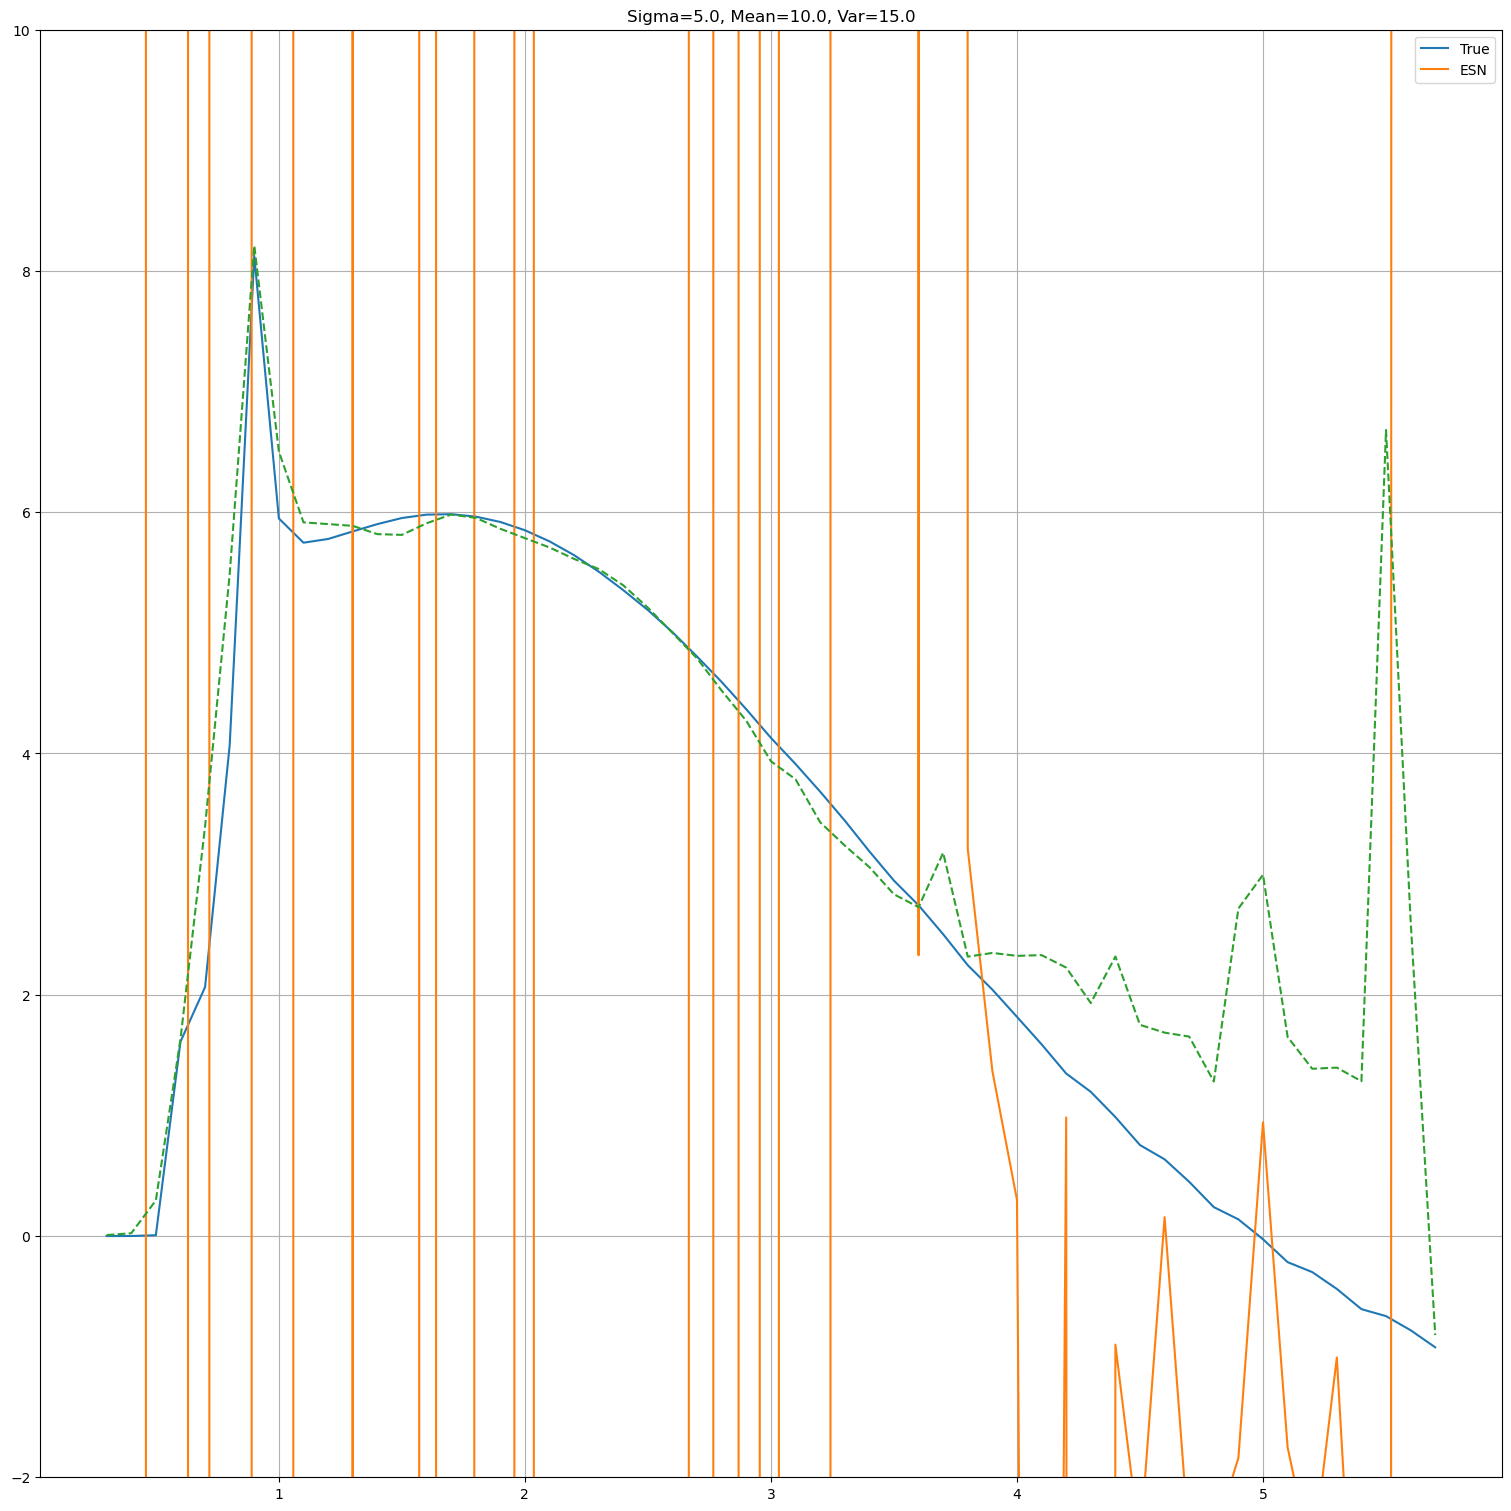

In [20]:
#sigma_list = np.arange(5.0,6.0,1.0)
#mean_list = np.arange(10.0,11.0,1.0)
#var_list = np.arange(15.0,16.0,1.0)
sigma_list = np.array([5.0])
mean_list = np.array([10.0])
var_list = np.array([15.0])
for s, sigma in enumerate(sigma_list):
    fig = plt.figure(figsize = (15,15), constrained_layout = True)
    for i, mean in enumerate(mean_list):
        for j, var in enumerate(var_list):
            print(f"Running Sigma={sigma}, Mean={mean}, Var={var}")
            my_ESN = ESN(reservoir_size = 1000, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = sigma, spectral_radius = 0.1,
                leak_factor = 1.0, 
                input_bias = np.array([]), 
                output_bias= np.array([]),
                input_normalization = input_scale, 
                parameter_normalization=[np.array([0.0]),np.array([1.0])],
                input_seeds=[0,1,2],reservoir_seeds=[3,4],
                verbose=False,
                r2_mode=True)
            
            my_ESN_old = ESN_old(reservoir_size = 1000, dimension = dim, parameter_dimension = 1, reservoir_connectivity = 3, 
                input_scaling = sigma, spectral_radius = 0.1,
                leak_factor = 1.0, 
                input_bias = input_bias, 
                input_normalization = input_scale, 
                parameter_normalization=[np.array([mean]),np.array(var)],
                input_seeds=[0,1,2],reservoir_seeds=[3,4],
                verbose=False)

            my_ESN.train(
            U_washout_train_noisy,
            U_train_noisy,
            Y_train,
            tikhonov=0.001,
            P_washout=P_washout_train,
            P_train=P_train,
            train_idx_list=train_idx_list,
            )

            my_ESN_old.train(
                U_washout_train_noisy,
                U_train_noisy,
                Y_train,
                tikhonov=0.001,
                P_washout=P_washout_train,
                P_train=P_train,
                train_idx_list=train_idx_list,
                )

            dJ_dbeta_esn = np.zeros(len(p_mesh2))
            dJ_dbeta_esn_old = np.zeros(len(p_mesh2))
            for p_idx in range(len(p_mesh2)):
                _, dJ_dbeta_esn[p_idx] = run_esn_grad_num(my_ESN,
                    U_washout_grad[p_idx],
                    500,
                    P_washout_grad[p_idx],
                    P_grad[p_idx],
                    N_g = 10)
                
                _, dJ_dbeta_esn_old[p_idx] = run_esn_grad_num(my_ESN_old,
                    U_washout_grad[p_idx],
                    500,
                    P_washout_grad[p_idx],
                    P_grad[p_idx],
                    N_g = 10)
                
            plt.subplot(len(mean_list),len(var_list),i*len(var_list)+j+1)
            #plt.subplot(1,len(mean_list),s+1)    
            plt.plot(p_mesh2[:,0],dJ_dbeta)
            plt.plot(p_mesh2[:,0],dJ_dbeta_esn)
            plt.plot(p_mesh2[:,0],dJ_dbeta_esn_old,'--')
            plt.legend(["True", "ESN"])
            plt.grid()
            plt.title(f"Sigma={sigma}, Mean={mean}, Var={var}")
            plt.ylim([-2,10])
    #fig.savefig(f"grid_grad_sigma_{sigma}_less_data.png")        

In [8]:
my_ESN.W_in.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.64005098],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -4.74073768],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.49662478],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.80391484],
       [ 0.        ,  0.        , -1.74032793, ...,  0.        ,
         0.        ,  3.53199812],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.92842528]])

In [9]:
my_ESN_old.W_in.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.64005098],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -4.74073768],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.49662478],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.80391484],
       [ 0.        ,  0.        , -1.74032793, ...,  0.        ,
         0.        ,  3.53199812],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  2.92842528]])

In [10]:
np.where(np.isclose(my_ESN.W_in.toarray(),my_ESN_old.W_in.toarray()) == False)

(array([], dtype=int64), array([], dtype=int64))

In [11]:
my_ESN.W_out[84,20]

0.0004779130092567722

In [12]:
my_ESN_old.W_out[84,20]

0.00047792964613912244